In [95]:
### General imports ###
import os
from glob import glob
import pickle
import itertools
import numpy as np
import pandas as pd
from scipy.stats import zscore
from sklearn.model_selection import train_test_split

### Graph imports ###
import matplotlib.pyplot as plt
from PIL import Image

### Audio import ###
import librosa
import librosa.display
import IPython
from IPython.display import Audio

# 1. RAVDESS

### 1.1 Dataset informations

Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS) https://www.kaggle.com/uwrfkaggler/ravdess-emotional-speech-audio

RAVDESS is one of the more common dataset used for this excercise by others. It's well liked because of its quality of speakers, recording and it has 24 actors of different genders. And there's more! You can get it in song format as well. There's something for everyone and their research project. So for convenience, here's the filename identifiers as per the official RAVDESS website:

- **Modality** (01 = full-AV, 02 = video-only, 03 = audio-only).

- **Vocal channel** (01 = speech, 02 = song).

- **Emotion** (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).

- **Emotional intensity** (01 = normal, 02 = strong). NOTE: There is no strong intensity for the ‘neutral’ emotion.

- **Statement** (01 = “Kids are talking by the door”, 02 = “Dogs are sitting by the door”).

- **Repetition** (01 = 1st repetition, 02 = 2nd repetition).

- **Actor** (01 to 24. Odd numbered actors are male, even numbered actors are female).

### 1.2 Dataset exploration

In [96]:
label_dict_ravdess = {'02': 'NEU', '03':'HAP', '04':'SAD', '05':'ANG', '06':'FEA', '07':'DIS', '08':'SUR'}

file_path = '../Data/RAVDESS/'
file_names = os.listdir(file_path)

In [97]:
emotions_list = []
gender_list = []

for audioFile_name in file_names:
    identifiers = audioFile_name.split('.')[0].split('-')
    if identifiers[2] in list(label_dict_ravdess.keys()):
        emotions_list.append(int(identifiers[2]))
        gender = int(identifiers[6])
        gender_list.append("female" if gender % 2 == 0 else "male")

In [98]:
len(gender_list)

1344

In [99]:
RAV_df = pd.DataFrame(emotions_list)
RAV_df = RAV_df.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
RAV_df = RAV_df.replace(label_dict_ravdess)
RAV_df = pd.concat([pd.DataFrame(gender_list), RAV_df], axis=1)
RAV_df.columns = ['gender', 'emotion']
print(RAV_df.emotion)
RAV_df['labels'] = RAV_df.gender + '_' + RAV_df.emotion
RAV_df['source'] = 'RAVDESS'  

0        neutral
1        neutral
2        neutral
3        neutral
4        neutral
          ...   
1339    surprise
1340    surprise
1341    surprise
1342    surprise
1343    surprise
Name: emotion, Length: 1344, dtype: object


In [100]:
RAV_df.labels.value_counts()

male_sad           96
male_fear          96
male_disgust       96
female_sad         96
male_happy         96
female_surprise    96
male_angry         96
female_disgust     96
male_neutral       96
female_fear        96
female_neutral     96
female_angry       96
female_happy       96
male_surprise      96
Name: labels, dtype: int64

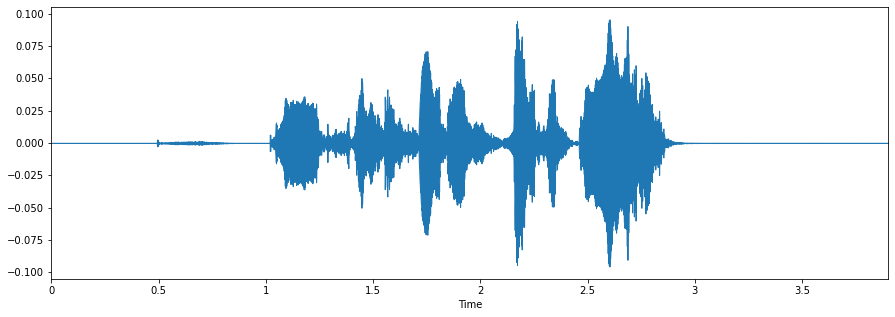

In [101]:
file_name = file_path + '03-01-04-02-02-02-14.wav'
data, sample_rate = librosa.load(file_name)
plt.figure(figsize=(15, 5))

librosa.display.waveplot(data, sr=sample_rate)
IPython.display.Audio(file_name)

In [103]:
sample_rate = 16000 

## 1.3 Loading and preprocessing

In [104]:
# Set audio files labels
def set_label_ravdess(audio_file, gender_differentiation):
    label = label_dict_ravdess.get(audio_file[6:-16])
    if gender_differentiation == True:
        if int(audio_file[18:-4])%2 == 0: # Female
            label = 'f_' + label
        if int(audio_file[18:-4])%2 == 1: # Male
            label = 'm_' + label
    return label

In [116]:
def normalize_signal(y, sample_rate = 16000, max_pad_len = 49100):
    # Z-normalization
    y = zscore(y)
            
    # Padding or truncated signal 
    if len(y) < max_pad_len:    
        y_padded = np.zeros(max_pad_len)
        y_padded[:len(y)] = y
        y = y_padded
    elif len(y) > max_pad_len:
        y = np.asarray(y[:max_pad_len])
    
    return y

def load_RAVDESS():
    # Start feature extraction
    print("Import Data: START")
    
    # Audio file path and names
    file_names = os.listdir(file_path)
    
    # Initialize features and labels list
    signal = []
    labels = []
    
    # Sample rate (16.0 kHz)
    sample_rate = 16000     
    
    # Max pad lenght (3.0 sec)
    max_pad_len = 49100
    
    for audio_index, audio_file in enumerate(file_names):
        # is in the labels (we tigone calm)
        if audio_file[6:-16] in list(label_dict_ravdess.keys()):
            
            # Read audio file
            y, sr = librosa.core.load(file_path + audio_file, sr=sample_rate, offset=0.5)
            
            # Normalize and Padd
            y = normalize_signal(y)
            
            # Add to signal list
            signal.append(y)
            
            # Set label
            labels.append(set_label_ravdess(audio_file, False))
    
            # Print running...
            if (audio_index % 100 == 0):
                print("Import Data: RUNNING ... {} files".format(audio_index))
            
    # Cast labels to array
    labels = np.asarray(labels).ravel()
    
    # Stop feature extraction
    print("Import Data: END \n")
    print("Number of audio files imported: {}".format(labels.shape[0]))
    
    return signal, labels

In [117]:
signal_ravdess, labels_ravdess = load_RAVDESS()

Import Data: START
Import Data: RUNNING ... 100 files
Import Data: RUNNING ... 200 files
Import Data: RUNNING ... 300 files
Import Data: RUNNING ... 400 files
Import Data: RUNNING ... 500 files
Import Data: RUNNING ... 600 files
Import Data: RUNNING ... 700 files
Import Data: RUNNING ... 800 files
Import Data: RUNNING ... 900 files
Import Data: RUNNING ... 1000 files
Import Data: RUNNING ... 1100 files
Import Data: RUNNING ... 1200 files
Import Data: RUNNING ... 1300 files
Import Data: RUNNING ... 1400 files
Import Data: END 

Number of audio files imported: 1344


In [119]:
# Number of augmented data
nb_augmented = 2

# Function to add noise to a signals with a desired Signal Noise ratio (SNR)
def noisy_signal(signal, snr_low=15, snr_high=30, nb_augmented=2):
    
    # Signal length
    signal_len = len(signal)

    # Generate White noise
    noise = np.random.normal(size=(nb_augmented, signal_len))
    
    # Compute signal and noise power
    s_power = np.sum((signal / (2.0 ** 15)) ** 2) / signal_len
    n_power = np.sum((noise / (2.0 ** 15)) ** 2, axis=1) / signal_len
    
    # Random SNR: Uniform [15, 30]
    snr = np.random.randint(snr_low, snr_high)
    
    # Compute K coeff for each noise
    K = np.sqrt((s_power / n_power) * 10 ** (- snr / 10))
    K = np.ones((signal_len, nb_augmented)) * K
    
    # Generate noisy signal
    return signal + K.T * noise

In [120]:
# Generate noisy signals from signal list
augmented_signal_ravdess = list(map(noisy_signal, signal_ravdess))

In [133]:
random_idx = np.random.randint(len(labels_ravdess))
random_signal_ravdess = signal_ravdess[random_idx]
random_label_ravdess = labels_ravdess[random_idx]
random_filename_ravdess = file_names[random_idx]

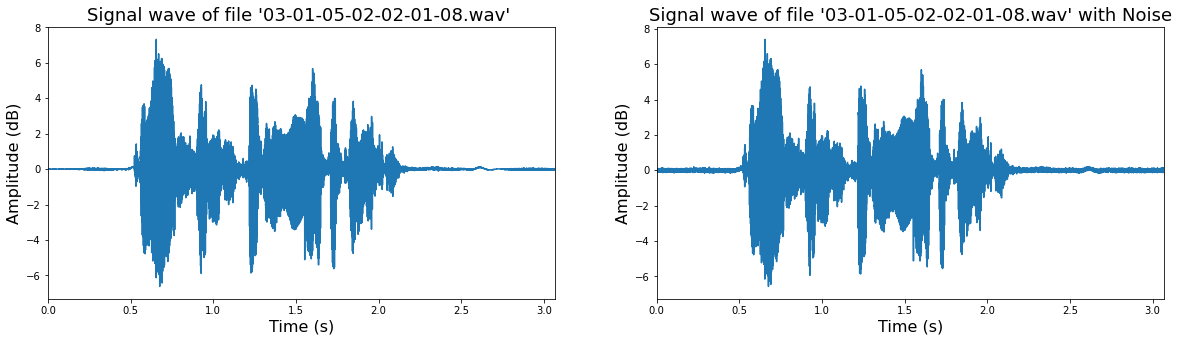

Audio file '03-01-05-02-02-01-08.wav'| FEA:


Audio file '03-01-05-02-02-01-08.wav' | FEA with noise:


In [134]:
# Plot signal wave
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(np.arange(len(random_signal_ravdess))/float(sample_rate), random_signal_ravdess)
plt.xlim((np.arange(len(random_signal_ravdess))/float(sample_rate))[0], (np.arange(len(random_signal_ravdess))/float(sample_rate))[-1])
plt.xlabel('Time (s)', fontsize=16)
plt.ylabel('Amplitude (dB)', fontsize=16)
plt.title("Signal wave of file '{}' ".format(random_filename_ravdess), fontsize=18)

# Plot signal wave with noise
plt.subplot(1,2,2)
plt.plot(np.arange(len(random_signal_ravdess))/float(sample_rate), augmented_signal_ravdess[random_idx][0])
plt.xlim((np.arange(len(random_signal_ravdess))/float(sample_rate))[0], (np.arange(len(random_signal_ravdess))/float(sample_rate))[-1])
plt.xlabel('Time (s)', fontsize=16)
plt.ylabel('Amplitude (dB)', fontsize=16)
plt.title("Signal wave of file '{}' with Noise".format(random_filename_ravdess), fontsize=18)
plt.show()

# Play audio file
print(f"Audio file '{random_filename_ravdess}'| {random_label_ravdess}:")
IPython.display.display(Audio(random_signal_ravdess, rate=sample_rate))

# Play same audio file with noise
print(f"Audio file '{random_filename_ravdess}' | {random_label_ravdess} with noise:")
IPython.display.display(Audio(augmented_signal_ravdess[random_idx][0], rate=sample_rate))

In [135]:
def mel_spectrogram(y, sr=16000, n_fft=512, win_length=256, hop_length=128, window='hamming', n_mels=128, fmax=4000):
    
    # Compute spectogram
    mel_spect = np.abs(librosa.stft(y, n_fft=n_fft, window=window, win_length=win_length, hop_length=hop_length)) ** 2
    
    # Compute mel spectrogram
    mel_spect = librosa.feature.melspectrogram(S=mel_spect, sr=sr, n_mels=n_mels, fmax=fmax)
    
    # Compute log-mel spectrogram
    mel_spect = librosa.power_to_db(mel_spect, ref=np.max)
    
    return mel_spect

In [136]:
# Compute spectogram for all audio file
mel_spect = np.asarray(list(map(mel_spectrogram, signal_ravdess)))
augmented_mel_spect = [np.asarray(list(map(mel_spectrogram, augmented_signal_ravdess[i]))) for i in range(len(augmented_signal_ravdess))]

In [138]:
mel_spect.shape

(1344, 128, 384)

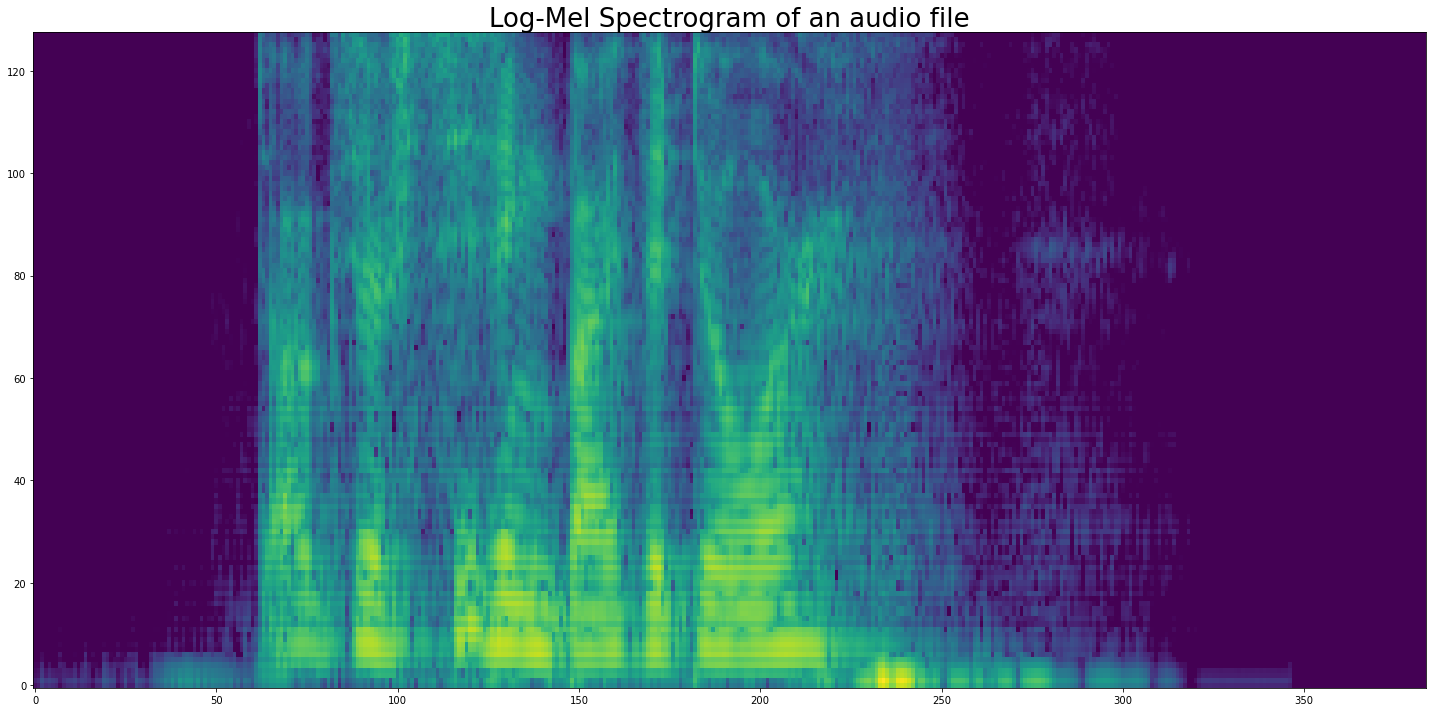

In [137]:
# Plot one random Spectogram 
plt.figure(figsize=(20, 10))
plt.imshow(mel_spect[np.random.randint(len(mel_spect))], origin='lower', aspect='auto', cmap='viridis')
plt.title('Log-Mel Spectrogram of an audio file', fontsize=26)
plt.tight_layout()
plt.show()